<a href="https://colab.research.google.com/github/mkxdxdxd/AIGS538/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_interval_mean_%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Settings

### 1) Import required libraries

In [2]:
import random
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### 2) Hyperparameters

In [3]:
learning_rate = 1e-3
batch_size = 100
epochs = 3000

# 2. Data

### 1) Generate data

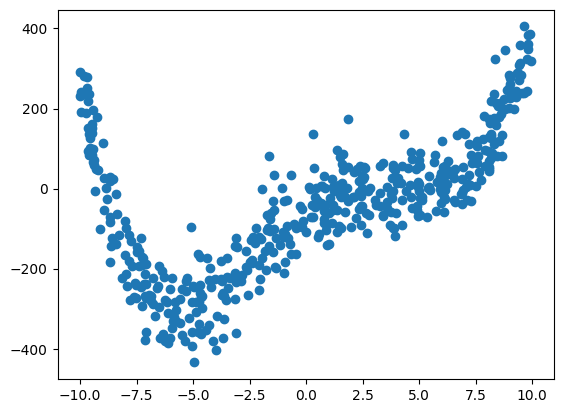

499


In [4]:
np.random.seed(1)

X = [np.random.uniform(-10,10) for _ in range(1, 500)]
X = torch.tensor(X, dtype = torch.float32)

Y = [0.1 * (value + 9) * ((value - 4) ** 3) for value in X]
noise = np.random.normal(0, 60, 499)
Y_gauss = Y + noise
Y_gauss = torch.tensor(Y_gauss, dtype = torch.float32)

plt.plot(X, Y_gauss,'o')
plt.show()
print(len(X))

In [5]:
X = X.unsqueeze(1) if X.dim() == 1 else X
Y_gauss = Y_gauss.unsqueeze(1) if Y_gauss.dim() == 1 else Y_gauss

#dataset 나누기 (4:3:3)
X_train, X_test, y_train, y_test = train_test_split(X, Y_gauss, test_size=0.6, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("train:", len(X_train))
print("test:", len(X_test))
print("val:", len(X_valid))

W_ones = torch.ones_like(X_train)

#dataset tensor로 변환
train_dataset = TensorDataset(X_train, y_train, W_ones)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_valid, y_valid)

dataloaders = {}
dataloaders['train'] = DataLoader(train_dataset, batch_size = batch_size, shuffle=False) # {100, 99}
dataloaders['test'] = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)  # {100, 49}
dataloaders['val'] = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)  # {100, 49}

# number of data/batch
len(dataloaders["val"])

train: 199
test: 150
val: 150


2

### 2) Dataset reduction

##### (a) interval mean algorithm

In [6]:
import copy

def interval_mean_reduction(X_train, y_train, N):
    num_vector = [[[] for i in range(N)] for j in range(N)] # N x N
    x_avg = [[0.0 for i in range(N)] for j in range(N)]
    y_avg = [[0.0 for i in range(N)] for j in range(N)]

    min_x = min(X_train)
    min_y = min(y_train)
    ux = (max(X_train)-min(X_train))/N
    uy = (max(y_train)-min(y_train))/N

    X_train_new = []
    y_train_new = []
    weight_num = []

    #범위 안의 것들 append
    for i, x in enumerate(X_train) :
        y = y_train[i]
        pair = np.array([x,y]).tolist()
        for l in range(0,N) :
          for k in range(0,N) :
            if (min_x + ux*k < x <= min_x + ux*(k+1)) and (min_y + uy*l < y <= min_y +uy*(l+1)) :
              num_vector[l][k].append(pair)

    #각 점의 average 구하기
    for j in range(0,N) :
      for i in range(0,N) :
        if len(num_vector[j][i]) !=0 :
          for k in range(int(len(num_vector[j][i]))) :
            x_avg[j][i] += num_vector[j][i][k][0]
            y_avg[j][i] += num_vector[j][i][k][1]
          x_avg[j][i] = x_avg[j][i]/len(num_vector[j][i])
          y_avg[j][i] = y_avg[j][i]/len(num_vector[j][i])
          weight_num.append(len(num_vector[j][i]))
          X_train_new.append(x_avg[j][i])
          y_train_new.append(y_avg[j][i])

    X_train_tensor = torch.tensor(X_train_new, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train_new, dtype=torch.float32).unsqueeze(1)
    weight_tensor = torch.tensor(weight_num, dtype=torch.float32)

    reduced_dataset = TensorDataset(X_train_tensor, y_train_tensor, weight_tensor)
    return reduced_dataset, X_train_new, y_train_new, weight_num

##### (b) dataloader with reduced dataset

In [7]:
X_train = X_train.squeeze(1) if X_train.dim() != 1 else X_train
y_train = y_train.squeeze(1) if y_train.dim() != 1 else y_train

Nrange = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130] # N이 110, 120일 때의 데이터 개수는 100일 때와 같음
reduced_X_dict = {}
reduced_y_dict = {}
reduced_W_dict = {}

def reduce_dataset(Nrange, X_train, y_train):
    for N in Nrange:
        print(f"=========={N}==========")
        reduced_tensor_dataset, reduced_X_dict[N], reduced_y_dict[N], reduced_W_dict[N]= interval_mean_reduction(X_train, y_train, N)
        dataloaders[f'train_{N}_reduced'] = DataLoader(reduced_tensor_dataset, batch_size=batch_size, shuffle=False)
        print("size of X: ", len(reduced_X_dict[N]))

reduce_dataset(Nrange, X_train, y_train)

==========2==========
size of X:  4
==========3==========
size of X:  8
==========4==========
size of X:  11
==========5==========
size of X:  15
==========6==========
size of X:  21
==========7==========
size of X:  27
==========8==========
size of X:  29
==========9==========
size of X:  37
==========10==========
size of X:  40
==========20==========
size of X:  101
==========30==========
size of X:  142
==========40==========
size of X:  156
==========50==========
size of X:  171
==========60==========
size of X:  176
==========70==========
size of X:  179
==========80==========
size of X:  184
==========90==========
size of X:  187
==========100==========
size of X:  189
==========110==========
size of X:  189
==========120==========
size of X:  189
==========130==========
size of X:  191


##### (c) plot reduced dataset

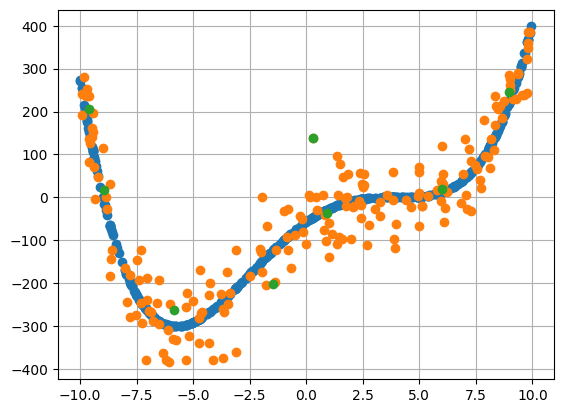

In [8]:
def plot_reduced_dataset(X_train, y_train, X_train_new, y_train_new):
    plt.plot(X, Y, 'o')
    plt.plot(X_train, y_train, 'o')
    plt.plot(X_train_new, y_train_new, 'o')
    plt.grid('true')
    plt.show()

plot_reduced_dataset(X_train, y_train, reduced_X_dict[3], reduced_y_dict[3])

#3. Training with reduced samples

### 1) Define model

In [9]:
class DNN(nn.Module):
  def __init__(self, input_size=1, output_size=1, hidden_units=30, num_hidden_layers=3):
    super(DNN, self).__init__()
    self.input_layer = nn.Linear(input_size, hidden_units)
    self.hidden_layers = nn.ModuleList([
        nn.Linear(hidden_units, hidden_units) for _ in range(num_hidden_layers)
    ])
    self.output_layer = nn.Linear(hidden_units, output_size)

  def forward(self, x):
    x = torch.relu(self.input_layer(x))
    for layer in self.hidden_layers:
      x = torch.relu(layer(x))
    x = self.output_layer(x)
    return x

### 2) Training

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    for batch, (X, y, W) in enumerate(dataloader):
        # prediction and loss calculation
        pred = model(X)
        loss = loss_fn(pred, y)
        weighted_loss = torch.mean(W * loss)
        # Backward propagation
        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            weighted_loss, current = weighted_loss.item(), (batch + 1) * len(X)
            history.append(weighted_loss)
    return history

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).mean().item()
    test_loss /= num_batches
    return test_loss

In [12]:
def train_and_test(dataloaders, num_hidden_layers, isReduction=False, reduction_size=3, epochs=3000, batch_size=100, learning_rate=0.001, debug=False):
    model = DNN(num_hidden_layers=num_hidden_layers).to(device)
    loss_func = nn.MSELoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_history = []
    test_loss_history = []
    train_data_name = f'train_{reduction_size}_reduced' if isReduction else 'train'

    for t in range(epochs):
        train_loss_history = train_loop(dataloaders[train_data_name], model, loss_func, optimizer, train_loss_history)
        test_loss = test_loop(dataloaders['test'], model, loss_func)
        test_loss_history.append(test_loss)
        if debug:
            print("# of hidden layer: ", num_hidden_layers)
            print(f"Epoch {t+1}")
            print(f"Training Loss: {train_loss_history[-1]:>7f}")
            print(f"Test Loss(Avg.): {test_loss:>8f} \n")
            print(f"---------------------\n")
    return model, train_loss_history, test_loss_history

def test_optimal_loss(dataloaders, model):
    loss_func = nn.MSELoss(reduction='none')
    test_loss = test_loop(dataloaders['test'], model, loss_func)
    print(f"Test Loss with optimal capacity: {test_loss:>8f} \n")
    return test_loss

##### (a) Learning Curve

In [13]:
def plot_learning_curve(train_loss_history, test_loss_history):
    plt.plot(test_loss_history, label='test')
    plt.plot(train_loss_history, label='train')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    print("Final Test Loss: ", test_loss_history[-1])

##### (b) True Function vs Model Prediction

In [14]:
def plot_model_prediction(model, X_train, y_train, X_test, y_test):
    x = torch.linspace(-10, 10, 1000).unsqueeze(1)
    y = model(x.to(device)).detach().cpu().numpy()

    plt.plot(X, Y, 'o', label='True Function', color = 'blue')
    plt.plot(x, y,'o', label='Model Prediction', color = 'orange')
    plt.plot(X_train, y_train, 'o', label = 'Training Samples', color = 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('True Function vs. Model Prediction')
    plt.legend()
    plt.show()

### 4) Model Selection

In [15]:
def train_and_evaluate(dataloaders, num_hidden_layers, isReduction=False, reduction_size=3, epochs=3000, batch_size=100, learning_rate=0.001, debug=False):
    model = DNN(num_hidden_layers=num_hidden_layers).to(device)
    loss_func = nn.MSELoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_data_name = f'train_{reduction_size}_reduced' if isReduction else 'train'
    train_loss_history = []

    for t in range(epochs):
        train_loss_history = train_loop(dataloaders[train_data_name], model, loss_func, optimizer, train_loss_history)
        if debug:
            print("# of hidden layer: ", num_hidden_layers)
            print(f"Epoch {t+1}")
            print(f"Training Loss: {train_loss_history[-1]:>7f}")
            print(f"---------------------\n")

    val_loss = test_loop(dataloaders['val'], model, loss_func)
    if debug:
        print(f"Eval Loss(Avg.): {val_loss:>8f} \n")

    return model, train_loss_history[-1], val_loss


def compute_simple_validation_curve(dataloaders, param_range, isReduction=False, reduction_size=3, epochs=3000, batch_size=100, learning_rate=0.001):
  train_scores = []
  eval_scores = []
  models = []

  for num_hidden_layers in param_range:
    start_time = time.time()

    model, train_loss, val_loss = train_and_evaluate(dataloaders, num_hidden_layers, isReduction, reduction_size, epochs, batch_size, learning_rate)
    train_scores.append(train_loss)
    eval_scores.append(val_loss)
    models.append(model)

    elapsed_time = time.time() - start_time
    print(f"Completed {num_hidden_layers}/{len(param_range)}: Hidden Layer Size {num_hidden_layers}, Time Taken: {elapsed_time:.2f} seconds")

  return models, np.array(train_scores), np.array(eval_scores)

##### (a) Validation curve

In [16]:
def plot_validation_curve(param_range, train_scores, test_scores):
    plt.plot(param_range, train_scores, color='blue', marker='o', markersize=5, label='Training Weighted Loss')
    plt.plot(param_range, test_scores, color='green', linestyle='--', marker='o', markersize=5, label='Validation MSE')
    plt.xlabel('Number of Hidden Layers')
    plt.ylabel('Weighted Loss')
    plt.title('Find adequate Capacity')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.show()

# 4. Results

### 1) example: N = 3

In [ ]:
param_range = range(1, 11)
reduced_models, reduced_train_scores, reduced_val_scores = compute_simple_validation_curve(dataloaders, param_range, isReduction=True, reduction_size=3)

Completed 1/10: Hidden Layer Size 1, Time Taken: 20.61 seconds
Completed 2/10: Hidden Layer Size 2, Time Taken: 6.99 seconds
Completed 3/10: Hidden Layer Size 3, Time Taken: 7.10 seconds
Completed 4/10: Hidden Layer Size 4, Time Taken: 6.61 seconds
Completed 5/10: Hidden Layer Size 5, Time Taken: 8.50 seconds
Completed 6/10: Hidden Layer Size 6, Time Taken: 8.47 seconds
Completed 7/10: Hidden Layer Size 7, Time Taken: 9.50 seconds
Completed 8/10: Hidden Layer Size 8, Time Taken: 10.57 seconds
Completed 9/10: Hidden Layer Size 9, Time Taken: 11.07 seconds
Completed 10/10: Hidden Layer Size 10, Time Taken: 12.01 seconds


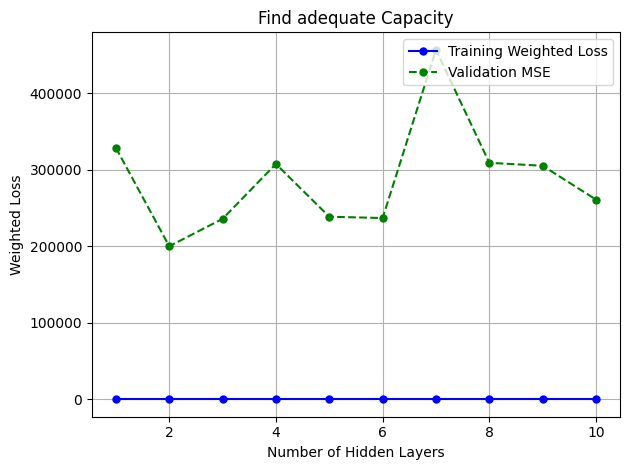

Minimum capacity: 2 with loss: 200140.625


In [ ]:
plot_validation_curve(param_range, reduced_train_scores, reduced_val_scores)

reduced_min_loss = min(reduced_val_scores)
reduced_min_capacity = np.argmin(reduced_val_scores)

print(f"Minimum capacity: {reduced_min_capacity + 1} with loss: {reduced_min_loss}")

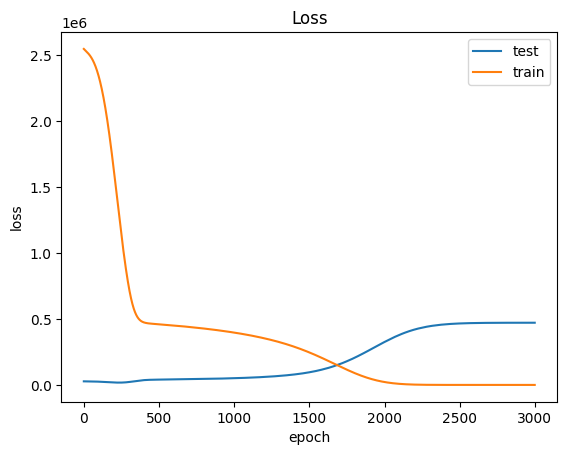

Final Test Loss:  471506.640625


In [ ]:
model_reduced3, r_train_loss_history, r_test_loss_history = train_and_test(dataloaders, num_hidden_layers = reduced_min_capacity, isReduction=True, reduction_size=3)

plot_learning_curve(r_train_loss_history, r_test_loss_history)

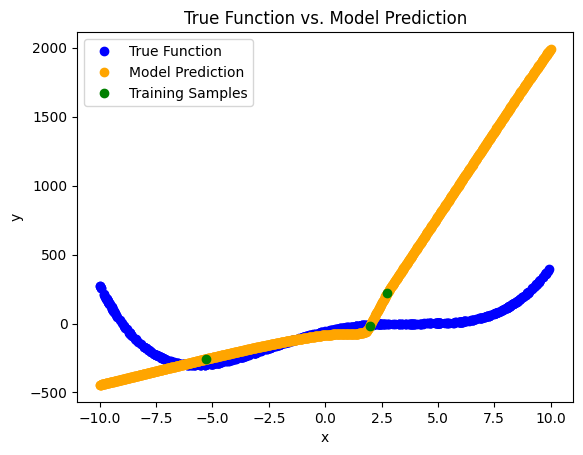

In [ ]:
plot_model_prediction(model_reduced3, reduced_X_dict[3], reduced_y_dict[3], X_train, y_train)

### 2) Whole result

In [ ]:
def init_history():
    H = {}
    H['models'] = {}
    H['train_scores'] = {}
    H['val_scores'] = {}
    H['min_loss'] = {}
    H['min_capacity'] = {}
    H['model'] = {}
    H['train_loss_history'] = {}
    H['test_loss_history'] = {}
    return H

def iter_reduction(keys, H):
    param_range = range(1, 11)

    for N in keys:
        print("# of reduced data size: ", N)
        H['models'][N], H['train_scores'][N], H['val_scores'][N] = compute_simple_validation_curve(dataloaders, param_range, isReduction=True, reduction_size=N)
        H['min_loss'][N] = min(H['val_scores'][N])
        H['min_capacity'][N] = np.argmin(H['val_scores'][N])

        print(f"Minimum capacity: {H['min_capacity'][N] + 1} with evaluation loss: {H['min_loss'][N]}")
        H['model'][N], H['train_loss_history'][N], H['test_loss_history'][N] = train_and_test(dataloaders, num_hidden_layers = H['min_capacity'][N], isReduction=True, reduction_size=N)
        print("Final Test Loss: ", H['test_loss_history'][N][-1])
        print(f"---------------------\n")

def plot_reduction(H, N):
    plot_reduced_dataset(X_train, y_train, reduced_X_dict[N], reduced_y_dict[N])
    plot_validation_curve(param_range, H['train_scores'][N], H['val_scores'][N])
    print(f"Minimum capacity: {H['min_capacity'][N] + 1} with evaluation loss: {H['min_loss'][N]}")
    plot_learning_curve(H['train_loss_history'][N], H['test_loss_history'][N])
    plot_model_prediction(H['model'][N], reduced_X_dict[N], reduced_y_dict[N], X_train, y_train)

In [ ]:
Nrange = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
reduced_history = init_history()
iter_reduction(Nrange, reduced_history)

# of reduced data size:  1
Completed 1/10: Hidden Layer Size 1, Time Taken: 4.40 seconds
Completed 2/10: Hidden Layer Size 2, Time Taken: 6.24 seconds
Completed 3/10: Hidden Layer Size 3, Time Taken: 6.56 seconds
Completed 4/10: Hidden Layer Size 4, Time Taken: 6.42 seconds
Completed 5/10: Hidden Layer Size 5, Time Taken: 8.05 seconds
Completed 6/10: Hidden Layer Size 6, Time Taken: 8.89 seconds
Completed 7/10: Hidden Layer Size 7, Time Taken: 8.26 seconds
Completed 8/10: Hidden Layer Size 8, Time Taken: 9.89 seconds
Completed 9/10: Hidden Layer Size 9, Time Taken: 10.82 seconds
Completed 10/10: Hidden Layer Size 10, Time Taken: 11.38 seconds
Minimum capacity: 4 with evaluation loss: 29516.1376953125
Final Test Loss:  36305.8125
---------------------

# of reduced data size:  3
Completed 1/10: Hidden Layer Size 1, Time Taken: 4.55 seconds
Completed 2/10: Hidden Layer Size 2, Time Taken: 5.12 seconds
Completed 3/10: Hidden Layer Size 3, Time Taken: 6.95 seconds
Completed 4/10: Hidden La

In [ ]:
for N in Nrange:
    plot_reduction(reduced_history, N)

In [17]:
def iter_fixed_capacity_reduction(Nrange, capacity):
    print(f"fixed capacity: {capacity}")
    for N in Nrange:
        print("# of reduced data size: ", N)
        model, train_loss_history, test_loss_history = train_and_test(dataloaders, num_hidden_layers=capacity, isReduction=True, reduction_size=N)
        # plot_learning_curve(train_loss_history, test_loss_history)
        # plot_model_prediction(model, reduced_X_dict[N], reduced_y_dict[N], X_train, y_train)
        print("Final Test Loss: ", test_loss_history[-1])
        print(f"---------------------\n")

    print("# of reduced data size: 199")
    model, train_loss_history, test_loss_history = train_and_test(dataloaders, num_hidden_layers=capacity)
    print("Final Test Loss: ", test_loss_history[-1])
    print(f"---------------------\n")

Nrange = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130]
iter_fixed_capacity_reduction(Nrange, 2)

fixed capacity: 2
# of reduced data size:  2
Final Test Loss:  13744.89111328125
---------------------

# of reduced data size:  3
Final Test Loss:  18626.5751953125
---------------------

# of reduced data size:  4
Final Test Loss:  13165.96142578125
---------------------

# of reduced data size:  5
Final Test Loss:  7167.573486328125
---------------------

# of reduced data size:  6
Final Test Loss:  9174.25927734375
---------------------

# of reduced data size:  7
Final Test Loss:  10933.078125
---------------------

# of reduced data size:  8
Final Test Loss:  5720.90625
---------------------

# of reduced data size:  9
Final Test Loss:  4086.366455078125
---------------------

# of reduced data size:  10
Final Test Loss:  4995.703857421875
---------------------

# of reduced data size:  20
Final Test Loss:  4119.4984130859375
---------------------

# of reduced data size:  30
Final Test Loss:  3991.75537109375
---------------------

# of reduced data size:  40
Final Test Loss:  3

In [ ]:
def iter_origin_data(capacity):
    print("# of reduced data size: 200")
    for N in range(1, 11):
        model, train_loss_history, test_loss_history = train_and_test(dataloaders, num_hidden_layers=capacity)
        print("Final Test Loss: ", test_loss_history[-1])
    print(f"---------------------\n")

fixed_capacity = 2

iter_fixed_capacity_reduction(cluster_dic.keys(), fixed_capacity)
iter_origin_data(fixed_capacity)